# McDonald's Basket Data Analysis - Clustering v2
## April 2018
### Dr Jose M Albornoz

This notebook performs a clustering analysis for the basket items found in data for all 7 Reading areas stores during September 2017

# 1.- Import necessary modules, define SQLContext

In [5]:
# Import required modules
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
style.use('fivethirtyeight')
%matplotlib inline

import datetime

In [6]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 2.- Load basket data

In [7]:
column_labels = ['store_number', 'time_period', 'time_of_day', 'business_date', 'pos_code', 'c6', 'total_cost', \
                 'unit_cost', 'quantity', 'food_cost', 'paper_cost', 'hour', 'transaction_time', 'transaction_date', \
                 'pos_id', 'unique_till_code', 'sale_number', 'menu_item_id', 'till_key', 'channel', 'c20', \
                 'sale_or_refund', 'eatin_eatout', 'eat_in_eatout_str', 'payment_type_id', 'payment_type']

In [8]:
df_basket1 = pd.read_csv("BasketDataReading7Sept_not15/000", names=column_labels, sep='|')

In [9]:
df_basket1.shape

(1278812, 26)

In [10]:
df_basket1.head()

,store_number,time_period,time_of_day,business_date,pos_code,c6,total_cost,unit_cost,quantity,food_cost,paper_cost,hour,transaction_time,transaction_date,pos_id,unique_till_code,sale_number,menu_item_id,till_key,channel,c20,sale_or_refund,eatin_eatout,eat_in_eatout_str,payment_type_id,payment_type
0,787,5,Evening,2017-09-17,2,NaN,0.74,0.74,1,0.0955,0.0033,21,2017-09-17 21:05:33,2017-09-17,POS0002:947136517,947136517,1,4800,1,FRONT COUNTER,1,Sale,0,Take Out,1,Cash
1,787,4,Dinner,2017-09-17,2,NaN,0.20,0.20,1,0.1554,0.0000,19,2017-09-17 19:34:03,2017-09-17,POS0002:947136508,947136508,1,4630,1,FRONT COUNTER,1,Sale,0,Take Out,1,Cash
2,787,2,Lunch,2017-09-17,20,NaN,0.77,0.77,1,0.0612,0.0325,13,2017-09-17 13:24:39,2017-09-17,POS0019:1051702100,1051702100,6,3025,2,DRIVE THRU,1,Sale,0,Take Out,1,Cash
3,787,2,Lunch,2017-09-17,20,NaN,0.00,0.00,1,0.0000,0.0000,13,2017-09-17 13:24:39,2017-09-17,POS0019:1051702100,1051702100,5,4833,2,DRIVE THRU,1,Sale,0,Take Out,1,Cash
4,787,2,Lunch,2017-09-17,20,NaN,2.97,2.97,1,0.4751,0.0348,13,2017-09-17 13:24:39,2017-09-17,POS0019:1051702100,1051702100,1,6150,2,DRIVE THRU,1,Sale,0,Take Out,1,Cash


In [11]:
df_basket1['time_of_day'].unique()

array(['Evening', 'Dinner', 'Lunch', 'Afternoon', 'Breakfast', 'Night'],
      dtype=object)

In [12]:
df_basket1['time_period'].unique()

array([5, 4, 2, 3, 1, 6])

## 2.1.- Convert transaction_time to datetime

In [13]:
df_basket1['transaction_time'] = pd.to_datetime(df_basket1['transaction_time'])

## 2.2.- Filter data by range of days

In [14]:
df_basket2 = df_basket1[(df_basket1['transaction_time'] >= datetime.date(2017,9,1)) & \
                         (df_basket1['transaction_time'] <= datetime.date(2017,9,5))]

In [15]:
df_basket2.shape

(218408, 26)

# 3.- Preprocessing

In [16]:
df_basket3 = df_basket2[['store_number', 'time_period', 'eatin_eatout', 'payment_type_id', \
                         'channel', 'menu_item_id', 'unit_cost']]

In [17]:
df_basket3.head()

,store_number,time_period,eatin_eatout,payment_type_id,channel,menu_item_id,unit_cost
573559,1262,2,0,2,DRIVE THRU,1146,1.24
573560,1262,2,0,2,DRIVE THRU,4834,0.00
573561,1262,2,0,2,DRIVE THRU,4903,1.33
573562,1262,2,0,2,DRIVE THRU,3030,1.01
573563,1262,2,0,2,DRIVE THRU,6120,3.07


In [18]:
df_basket3['unit_cost'].unique()

array([ 1.24,  0.  ,  1.33,  1.01,  3.07,  0.59,  1.57,  2.97,  0.71,
        1.66,  0.77,  3.33,  0.49,  0.2 , -0.62, -0.5 ,  0.82,  3.43,
        3.01,  2.19,  0.83,  0.91,  1.99,  3.41,  1.07, -0.52,  2.99,
        0.87,  2.95,  2.93,  3.49,  2.49,  1.62,  2.31,  3.38,  1.11,
        0.74,  0.17,  1.16,  2.83,  4.48,  1.85,  0.16,  4.46,  4.29,
       -0.42,  2.07,  1.41, -0.48,  2.74,  1.63,  4.65,  0.62,  2.96,
        1.59,  0.9 , -0.4 ,  2.16, -0.46,  2.28,  1.15,  4.56,  1.02,
        2.41,  3.37,  1.38,  3.84, -0.7 ,  0.25,  4.07,  3.93,  2.57,
       -0.33,  2.12,  4.6 ,  1.06, -0.82,  3.15,  3.16,  0.66,  1.19,
        1.67,  3.1 ,  1.2 , -0.68,  3.83,  3.17, -0.55,  4.45,  1.45,
        1.69,  1.91,  1.49,  3.  ,  0.58,  1.81,  0.19,  3.97,  0.97,
        3.11,  4.5 ,  3.7 ,  1.74,  2.  ,  3.29,  0.13,  1.39,  1.34,
       -0.45,  3.24,  3.14,  1.56,  3.53,  2.17, -0.43,  1.84,  0.14,
        1.51,  4.4 ,  2.33,  3.02,  4.52,  0.99,  3.64,  3.72,  4.26,
        1.89,  2.08,

In [19]:
len(df_basket3['unit_cost'].unique())

282

## 3.1.- Exclude items with zero or negative cost

In [20]:
df_basket3 = df_basket3[(df_basket3['unit_cost'] != 0) & (df_basket3['unit_cost'] >= 0)]

In [21]:
df_basket3['unit_cost'].unique()

array([1.24, 1.33, 1.01, 3.07, 0.59, 1.57, 2.97, 0.71, 1.66, 0.77, 3.33,
       0.49, 0.2 , 0.82, 3.43, 3.01, 2.19, 0.83, 0.91, 1.99, 3.41, 1.07,
       2.99, 0.87, 2.95, 2.93, 3.49, 2.49, 1.62, 2.31, 3.38, 1.11, 0.74,
       0.17, 1.16, 2.83, 4.48, 1.85, 0.16, 4.46, 4.29, 2.07, 1.41, 2.74,
       1.63, 4.65, 0.62, 2.96, 1.59, 0.9 , 2.16, 2.28, 1.15, 4.56, 1.02,
       2.41, 3.37, 1.38, 3.84, 0.25, 4.07, 3.93, 2.57, 2.12, 4.6 , 1.06,
       3.15, 3.16, 0.66, 1.19, 1.67, 3.1 , 1.2 , 3.83, 3.17, 4.45, 1.45,
       1.69, 1.91, 1.49, 3.  , 0.58, 1.81, 0.19, 3.97, 0.97, 3.11, 4.5 ,
       3.7 , 1.74, 2.  , 3.29, 0.13, 1.39, 1.34, 3.24, 3.14, 1.56, 3.53,
       2.17, 1.84, 0.14, 1.51, 4.4 , 2.33, 3.02, 4.52, 0.99, 3.64, 3.72,
       4.26, 1.89, 2.08, 1.9 , 3.34, 3.48, 2.24, 1.7 , 1.61, 1.65, 1.82,
       0.09, 3.71, 2.91, 3.91, 1.83, 2.66, 0.57, 3.52, 0.21, 0.23, 4.43,
       1.29, 4.35, 2.22, 2.79, 2.23, 4.28, 3.05, 4.57, 3.57, 1.64, 4.64,
       4.3 , 0.41, 0.4 , 1.35, 2.13, 2.87, 4.02, 2.

In [22]:
len(df_basket3['unit_cost'].unique())

245

In [23]:
len(df_basket3['menu_item_id'].unique())

473

In [24]:
df_basket3.shape

(141446, 7)

## 3.1.- Encode channel

In [25]:
df_basket3['channel'].unique()

array(['DRIVE THRU', 'FRONT COUNTER', 'KIOSK'], dtype=object)

In [26]:
channel_mapping = {label:idx for idx,label in enumerate(np.unique(df_basket3['channel']))}

In [27]:
channel_mapping

{'DRIVE THRU': 0, 'FRONT COUNTER': 1, 'KIOSK': 2}

In [28]:
df_basket3['channel'] = df_basket3['channel'].map(channel_mapping)

In [29]:
df_basket3.head()

,store_number,time_period,eatin_eatout,payment_type_id,channel,menu_item_id,unit_cost
573559,1262,2,0,2,0,1146,1.24
573561,1262,2,0,2,0,4903,1.33
573562,1262,2,0,2,0,3030,1.01
573563,1262,2,0,2,0,6120,3.07
573565,102,5,0,1,1,4903,1.33


## 3.2.- Encoding summary

time_of_day: 

* 1 for breakfast 
* 2 for lunch
* 3 for afternoon
* 4 for dinner 
* 5 for evening
* 6 for night
             
eatin_eatout: 
* 0 for take-out 
* 1 for eat-in             

payment_type_id: 
* 1 for cash 
* 2 for cashless

channel: 
* 0 for drive-thru 
* 1 for front counter 
* 2 for kiosk 
* 3 for mobile

# 4.- Feature selection

In [30]:
# df_basket2 = df_basket1[['time_period', 'eatin_eatout', 'payment_type_id', \
#                          'channel', 'menu_item_id', 'unit_cost']]

In [31]:
#df_basket4 = df_basket3[['time_period', 'eatin_eatout']]

In [32]:
df_basket4 = df_basket3[['time_period', 'menu_item_id']]

# 5.- Clustering

## 5.1.- Scaling 

In [33]:
X_raw = df_basket4.values

In [34]:
X_raw

array([[   2, 1146],
       [   2, 4903],
       [   2, 3030],
       ...,
       [   2, 3711],
       [   2, 2880],
       [   2, 3810]])

In [35]:
X = StandardScaler().fit_transform(X_raw)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 5.2.- Running DBSCAN

In [36]:
db = DBSCAN(eps=0.20, min_samples=100).fit(X)

In [37]:
# create an array of zeros with the same lenght of the cluster labels
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)

In [38]:
# sets mask values to True
core_samples_mask[db.core_sample_indices_] = True

In [39]:
labels = db.labels_

In [40]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [41]:
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 12


# 6.- Visualisation

Text(0,0.5,'Item ID')

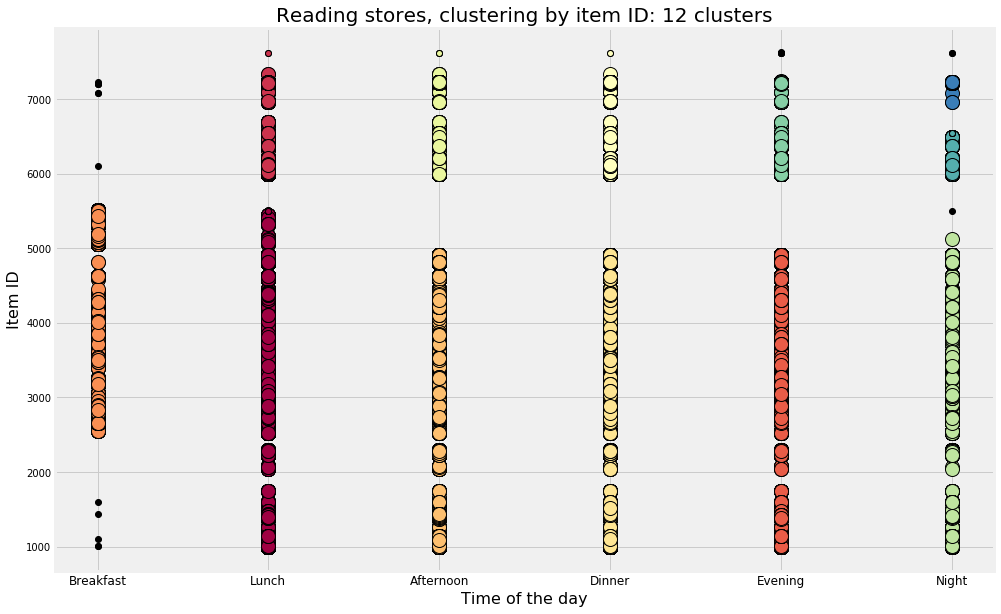

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = X_raw[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = X_raw[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Reading stores, clustering by item ID: %d clusters' % n_clusters_, fontsize=20)
plt.xlabel('Time of the day', fontsize=16)
x_labels = ['', 'Breakfast', 'Lunch', 'Afternoon', 'Dinner', 'Evening', 'Night']
ax.set_xticklabels(x_labels, fontsize=12)
plt.ylabel('Item ID', fontsize=16)
#plt.savefig('clusterByPrice.png', dpi=150)

In [43]:
unique_labels

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

# 7.- Cluster and time of day

In [44]:
for i in range(0,12):
    
    class_member_mask = (labels == i)
    
    df_tmp = df_basket3[class_member_mask]
    
    print('cluster %s associated to time period %s' % (i, df_tmp.iloc[0,1]))  

cluster 0 associated to time period 2
cluster 1 associated to time period 2
cluster 2 associated to time period 5
cluster 3 associated to time period 1
cluster 4 associated to time period 3
cluster 5 associated to time period 4
cluster 6 associated to time period 4
cluster 7 associated to time period 3
cluster 8 associated to time period 6
cluster 9 associated to time period 5
cluster 10 associated to time period 6
cluster 11 associated to time period 6


# 7.- Menu item identification

## 7.0.- Read menu item data

In [49]:
df_menu = pd.read_csv('other_datasets/MenuItemID.csv', names =['token', 'item_number', 'name1', 'name2', 'name3'])

In [52]:
df_menu.head(5)

,token,item_number,name1,name2,name3
0,826,443,Unknown,Unknown,Unknown
1,826,444,Unknown,Unknown,Unknown
2,826,445,Unknown,Unknown,Unknown
3,826,470,Not in use,Not in use,Not in use
4,826,471,Not in use,Not in use,Not in use


In [53]:
df_menu.dtypes

token           int64
item_number     int64
name1          object
name2          object
name3          object
dtype: object

## 7.1.- Breakfast items

In [54]:
breakfast_mask = (labels == 3)

In [55]:
df_breakfast = df_basket3[breakfast_mask]
df_breakfast.shape

(15638, 7)

In [56]:
df_breakfast.head(5)

,store_number,time_period,eatin_eatout,payment_type_id,channel,menu_item_id,unit_cost
573580,1339,1,0,1,0,5125,3.33
573617,1339,1,0,2,0,5125,3.33
573641,1339,1,0,1,1,5320,2.99
573764,960,1,0,2,1,5105,2.07
573766,960,1,0,2,1,5125,3.33


In [57]:
breakfast_items = df_breakfast['menu_item_id'].unique()

In [58]:
breakfast_items.shape

(171,)

In [59]:
df_menu[df_menu['item_number'].isin(breakfast_items)]

,token,item_number,name1,name2,name3
1065,826,2550,M RASPBERY RIPPLE,M RASPBERY RIPPLE,M RASPBERY RIPPLE
1066,826,2551,L RASPBERY RIPPLE,L RASPBERY RIPPLE,L RASPBERY RIPPLE
1071,826,2556,M RASPBRY RIPLE(BRK),M RASPBRY RIPLE(BRK),M RASPBRY RIPLE(BRK)
1072,826,2557,L RASPBRY RIPLE(BRK),L RASPBRY RIPLE(BRK),L RASPBRY RIPLE(BRK)
1126,826,2655,M LATTE-TOFFEE,M LATTE-TOFFEE,M LATTE-TOFFEE
1127,826,2656,L LATTE-TOFFEE,L LATTE-TOFFEE,L LATTE-TOFFEE
1130,826,2659,M LATTE-TOFFEE(UPL),M LATTE-TOFFEE(UPL),M LATTE-TOFFEE(UPL)
1132,826,2661,M LATTE-TOFFEE(BRK),M LATTE-TOFFEE(BRK),M LATTE-TOFFEE(BRK)
1133,826,2662,L LATTE-TOFFEE(BRK),L LATTE-TOFFEE(BRK),L LATTE-TOFFEE(BRK)
1137,826,2666,M WILDBERRY SMOOTHIE,M WILDBERRY SMOOTHIE,M WILDBERRY SMOOTHIE


In [61]:
df_menu[df_menu['item_number'].isin(breakfast_items)].shape

(171, 5)

## 7.2.- Lunch items

In [62]:
lunch_mask = (labels == 0) | (labels == 1)

In [63]:
df_lunch = df_basket3[lunch_mask]
df_lunch.shape

(42337, 7)

In [64]:
df_lunch.head(5)

,store_number,time_period,eatin_eatout,payment_type_id,channel,menu_item_id,unit_cost
573559,1262,2,0,2,0,1146,1.24
573561,1262,2,0,2,0,4903,1.33
573562,1262,2,0,2,0,3030,1.01
573563,1262,2,0,2,0,6120,3.07
573568,787,2,0,1,1,3020,0.59


In [65]:
lunch_items = df_lunch['menu_item_id'].unique()

In [66]:
lunch_items.shape

(384,)

In [67]:
df_menu[df_menu['item_number'].isin(lunch_items)]

,token,item_number,name1,name2,name3
19,826,1000,HAMBURGER,HAMBURGER,HAMBURGER
29,826,1010,CHEESEBURGER,CHEESEBURGER,CHEESEBURGER
79,826,1060,QUARTER CHEESE,QUARTER CHEESE,QUARTER CHEESE
98,826,1094,Chicken BBQ BLC ALC,Chicken BBQ BLC ALC,Chicken BBQ BLC ALC
104,826,1100,BIG MAC,BIG MAC,BIG MAC
115,826,1111,HS-MAC+M DRK,HS-MAC+M DRK,HS-MAC+M DRK
116,826,1112,HS-CHK+M DRK,HS-CHK+M DRK,HS-CHK+M DRK
147,826,1146,DOUBLE CHB,DOUBLE CHB,DOUBLE CHB
151,826,1150,HS-DBL+L FRY,HS-DBL+L FRY,HS-DBL+L FRY
213,826,1231,BACON BIG TASTY,BACON BIG TASTY,BACON BIG TASTY


In [68]:
df_menu[df_menu['item_number'].isin(lunch_items)].shape

(384, 5)

In [109]:
df_lunch[df_lunch['menu_item_id'] == 5310].head()

,store_number,time_period,eatin_eatout,payment_type_id,channel,menu_item_id,unit_cost
611696,1339,2,0,2,0,5310,2.99
657992,1339,2,0,1,0,5310,2.99
681092,1339,2,0,2,0,5310,2.99
733137,787,2,0,2,0,5310,2.91


## 7.3.- Afternoon items

In [69]:
afternoon_mask = (labels == 4) | (labels == 7)

In [70]:
df_afternoon = df_basket3[afternoon_mask]
df_afternoon.shape

(32483, 7)

In [71]:
df_afternoon.head(5)

,store_number,time_period,eatin_eatout,payment_type_id,channel,menu_item_id,unit_cost
573585,980,3,0,2,2,2882,1.57
573587,980,3,0,2,2,2881,1.57
573588,980,3,0,2,2,3711,0.59
573591,980,3,0,2,2,3711,0.59
573593,980,3,0,2,2,2865,0.49


In [72]:
afternoon_items = df_afternoon['menu_item_id'].unique()

In [73]:
afternoon_items.shape

(349,)

In [75]:
df_menu[df_menu['item_number'].isin(afternoon_items)]

,token,item_number,name1,name2,name3
19,826,1000,HAMBURGER,HAMBURGER,HAMBURGER
29,826,1010,CHEESEBURGER,CHEESEBURGER,CHEESEBURGER
79,826,1060,QUARTER CHEESE,QUARTER CHEESE,QUARTER CHEESE
98,826,1094,Chicken BBQ BLC ALC,Chicken BBQ BLC ALC,Chicken BBQ BLC ALC
104,826,1100,BIG MAC,BIG MAC,BIG MAC
147,826,1146,DOUBLE CHB,DOUBLE CHB,DOUBLE CHB
151,826,1150,HS-DBL+L FRY,HS-DBL+L FRY,HS-DBL+L FRY
213,826,1231,BACON BIG TASTY,BACON BIG TASTY,BACON BIG TASTY
217,826,1235,BIG TASTY,BIG TASTY,BIG TASTY
241,826,1263,CLASSIC PREMIUM BEEF,CLASSIC PREMIUM BEEF,CLASSIC PREMIUM BEEF


In [77]:
df_menu[df_menu['item_number'].isin(afternoon_items)].shape

(349, 5)

## 7.4.- Dinner items

In [78]:
dinner_mask = (labels == 5) | (labels == 6)

In [79]:
df_dinner = df_basket3[dinner_mask]
df_dinner.shape

(27599, 7)

In [80]:
df_dinner.head(5)

,store_number,time_period,eatin_eatout,payment_type_id,channel,menu_item_id,unit_cost
573594,1262,4,0,2,1,4630,0.20
573597,1262,4,0,2,1,2730,1.57
573601,1262,4,0,2,1,3275,0.82
573602,1262,4,0,2,1,3025,0.82
573603,1262,4,0,2,1,7233,3.43


In [81]:
dinner_items = df_dinner['menu_item_id'].unique()

In [82]:
dinner_items.shape

(338,)

In [83]:
df_menu[df_menu['item_number'].isin(dinner_items)]

,token,item_number,name1,name2,name3
19,826,1000,HAMBURGER,HAMBURGER,HAMBURGER
29,826,1010,CHEESEBURGER,CHEESEBURGER,CHEESEBURGER
79,826,1060,QUARTER CHEESE,QUARTER CHEESE,QUARTER CHEESE
98,826,1094,Chicken BBQ BLC ALC,Chicken BBQ BLC ALC,Chicken BBQ BLC ALC
104,826,1100,BIG MAC,BIG MAC,BIG MAC
115,826,1111,HS-MAC+M DRK,HS-MAC+M DRK,HS-MAC+M DRK
147,826,1146,DOUBLE CHB,DOUBLE CHB,DOUBLE CHB
151,826,1150,HS-DBL+L FRY,HS-DBL+L FRY,HS-DBL+L FRY
213,826,1231,BACON BIG TASTY,BACON BIG TASTY,BACON BIG TASTY
217,826,1235,BIG TASTY,BIG TASTY,BIG TASTY


In [84]:
df_menu[df_menu['item_number'].isin(dinner_items)].shape

(338, 5)

## 7.5.- Evening items

In [85]:
evening_mask = (labels == 2) | (labels == 9)

In [86]:
df_evening = df_basket3[evening_mask]
df_evening.shape

(17416, 7)

In [87]:
df_evening.head(5)

,store_number,time_period,eatin_eatout,payment_type_id,channel,menu_item_id,unit_cost
573565,102,5,0,1,1,4903,1.33
573619,1339,5,0,1,0,4810,0.91
573621,1339,5,0,1,0,3005,0.83
573622,1339,5,0,1,0,1442,0.83
573623,1339,5,0,1,0,3055,0.83


In [88]:
evening_items = df_evening['menu_item_id'].unique()

In [89]:
evening_items.shape

(322,)

In [90]:
df_menu[df_menu['item_number'].isin(evening_items)]

,token,item_number,name1,name2,name3
19,826,1000,HAMBURGER,HAMBURGER,HAMBURGER
29,826,1010,CHEESEBURGER,CHEESEBURGER,CHEESEBURGER
79,826,1060,QUARTER CHEESE,QUARTER CHEESE,QUARTER CHEESE
98,826,1094,Chicken BBQ BLC ALC,Chicken BBQ BLC ALC,Chicken BBQ BLC ALC
104,826,1100,BIG MAC,BIG MAC,BIG MAC
115,826,1111,HS-MAC+M DRK,HS-MAC+M DRK,HS-MAC+M DRK
116,826,1112,HS-CHK+M DRK,HS-CHK+M DRK,HS-CHK+M DRK
147,826,1146,DOUBLE CHB,DOUBLE CHB,DOUBLE CHB
151,826,1150,HS-DBL+L FRY,HS-DBL+L FRY,HS-DBL+L FRY
213,826,1231,BACON BIG TASTY,BACON BIG TASTY,BACON BIG TASTY


In [91]:
df_menu[df_menu['item_number'].isin(evening_items)].shape

(322, 5)

## 7.6.- Night items

In [92]:
night_mask = (labels == 8) | (labels == 10) | (labels == 11)

In [93]:
df_night = df_basket3[night_mask]
df_night.shape

(5953, 7)

In [94]:
df_night.head(5)

,store_number,time_period,eatin_eatout,payment_type_id,channel,menu_item_id,unit_cost
573771,960,6,0,2,0,4589,0.83
573789,102,6,0,2,2,1235,3.49
573790,102,6,0,2,2,4903,1.33
573791,102,6,0,2,2,1427,2.74
573836,102,6,0,2,2,3780,0.82


In [95]:
night_items = df_night['menu_item_id'].unique()

In [96]:
night_items.shape

(280,)

In [97]:
df_menu[df_menu['item_number'].isin(night_items)]

,token,item_number,name1,name2,name3
19,826,1000,HAMBURGER,HAMBURGER,HAMBURGER
29,826,1010,CHEESEBURGER,CHEESEBURGER,CHEESEBURGER
79,826,1060,QUARTER CHEESE,QUARTER CHEESE,QUARTER CHEESE
98,826,1094,Chicken BBQ BLC ALC,Chicken BBQ BLC ALC,Chicken BBQ BLC ALC
104,826,1100,BIG MAC,BIG MAC,BIG MAC
147,826,1146,DOUBLE CHB,DOUBLE CHB,DOUBLE CHB
151,826,1150,HS-DBL+L FRY,HS-DBL+L FRY,HS-DBL+L FRY
213,826,1231,BACON BIG TASTY,BACON BIG TASTY,BACON BIG TASTY
217,826,1235,BIG TASTY,BIG TASTY,BIG TASTY
241,826,1263,CLASSIC PREMIUM BEEF,CLASSIC PREMIUM BEEF,CLASSIC PREMIUM BEEF


In [98]:
df_menu[df_menu['item_number'].isin(night_items)].shape

(280, 5)

# 8.- Items sold during lunch that are not sold again during the day

In [99]:
df_lunch_only = df_lunch[(df_lunch['menu_item_id'] > 5000) & (df_lunch['menu_item_id'] < 5500)]

In [100]:
df_lunch_only.shape

(118, 7)

In [101]:
lunch_only_items = df_lunch_only['menu_item_id'].unique()

In [102]:
lunch_only_items.shape

(26,)

In [103]:
lunch_only_items

array([5441, 5120, 5320, 5127, 5125, 5437, 5439, 5160, 5095, 5310, 5080,
       5155, 5105, 5438, 5098, 5430, 5091, 5170, 5056, 5096, 5090, 5442,
       5157, 5403, 5092, 5407])

In [105]:
df_menu[df_menu['item_number'].isin(lunch_only_items)]

,token,item_number,name1,name2,name3
2949,826,5056,Cheesey Bacon Flatbread,Cheesey Bacon Flatbread,Cheesey Bacon Flatbread
2973,826,5080,SAUS+EGG MUFFIN,SAUS+EGG MUFFIN,SAUS+EGG MUFFIN
2983,826,5090,BAC+EGG MUFFIN,BAC+EGG MUFFIN,BAC+EGG MUFFIN
2984,826,5091,ROLL BROWN,ROLL BROWN,ROLL BROWN
2985,826,5092,EVM ROLL-BROWN,EVM ROLL-BROWN,EVM ROLL-BROWN
2988,826,5095,EGG MUFFIN,EGG MUFFIN,EGG MUFFIN
2989,826,5096,ROLL-KETCHUP,ROLL-KETCHUP,ROLL-KETCHUP
2991,826,5098,EVM ROLL-KETCHUP,EVM ROLL-KETCHUP,EVM ROLL-KETCHUP
2997,826,5105,DBL SAUS+EGG,DBL SAUS+EGG,DBL SAUS+EGG
3011,826,5120,EVM DBL BAC+EGG,EVM DBL BAC+EGG,EVM DBL BAC+EGG


In [106]:
df_menu[df_menu['item_number'].isin(lunch_only_items)].shape

(26, 5)

In [107]:
df_lunch[df_lunch['menu_item_id'].isin([5127, 5157, 5610])].shape

(6, 7)